# Autoencoder

In [1]:
import torch; torch.manual_seed(0)
import torch.nn as nn
import torch.nn.functional as F
import torch.utils
import torch.distributions
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

## Prep data

In [3]:
raw_data = np.loadtxt("../data/shuffled_data/repeat_shuffle_train.csv", delimiter=",", dtype=float)

In [4]:
raw_data = torch.tensor(raw_data).float() # convert to float32

In [210]:
NN = 40
data = raw_data.T[:,:NN] # take first NN neurons for now
data.shape

torch.Size([226814, 40])

In [211]:
# split into training and validation data
np.random.seed(42)
split = int(0.8 * data.shape[0])
indices = np.arange(data.shape[0])
np.random.shuffle(indices)
train_data = data[indices[:split]]
val_data = data[indices[split:]]

In [212]:
non_zero_train_data = train_data[train_data.sum(axis=1)!=0]

In [213]:
BATCH_SIZE = 32
train_data_loader = torch.utils.data.DataLoader(
    train_data,
    batch_size=BATCH_SIZE,
    shuffle=True)
non_zero_train_data_loader = torch.utils.data.DataLoader(
    non_zero_train_data,
    batch_size=BATCH_SIZE,
    shuffle=True)
zero_data_loader = torch.utils.data.DataLoader(torch.zeros((100,NNs)), batch_size=BATCH_SIZE)

## Define model

In [214]:
def init_weights(layer,fill_bias=0):
    #torch.nn.init.constant_(layer.bias, fill_bias)
    torch.nn.init.orthogonal_(layer.weight,gain=np.sqrt(2))

In [215]:
class VariationalEncoder(nn.Module):
    def __init__(self, 
                 enc_layer_dims : "list of at least 2 ints specifying input dims for each layer, e.g. [160,10,2]",
                 mu_layer_dims: "list of at least 2 ints specifying dims for network for learning mus",
                 sigma_layer_dims: "list of at least 2 ints specifying dims for network for learning mus"):
        super(VariationalEncoder, self).__init__()
        
        self.enc_layers = nn.ModuleList([])
        self.mu_layers = nn.ModuleList([])
        self.sigma_layers = nn.ModuleList([])
        
        for i in range(1,len(enc_layer_dims)):
            self.enc_layers.append(nn.Linear(enc_layer_dims[i-1], enc_layer_dims[i]))
            init_weights(self.enc_layers[-1])
            
        for i in range(1,len(mu_layer_dims)):
            self.mu_layers.append(nn.Linear(mu_layer_dims[i-1], mu_layer_dims[i]))
            init_weights(self.mu_layers[-1])
            
        for i in range(1,len(sigma_layer_dims)):
            self.sigma_layers.append(nn.Linear(sigma_layer_dims[i-1], sigma_layer_dims[i]))
            init_weights(self.sigma_layers[-1])
        
        # also define standard normal dist for sampling
        self.N = torch.distributions.Normal(0, 1)
#         self.N.loc = self.N.loc.cuda() # hack to get sampling on the GPU
#         self.N.scale = self.N.scale.cuda()
        self.kl = 0
    
    def forward(self, x):
        for layer in self.enc_layers[:-1]: # encode
            x = F.relu(layer(x))
        x =  self.enc_layers[-1](x)
        
        # map encoding to mu
        mu = x
        for layer in self.mu_layers[:-1]: # map encoding to mus
            mu = F.relu(layer(mu))
        mu = self.mu_layers[-1](mu)
        
        # map encoding to sigma
        sigma = x
        for layer in self.sigma_layers[:-1]: # map encoding to sigma
            sigma = F.relu(layer(sigma))
        sigma = torch.exp( self.sigma_layers[-1](sigma) )
        
        # sample from latent dist
        z = mu + sigma*self.N.sample(mu.shape)
        self.kl = (sigma**2 + mu**2 - torch.log(sigma) - 1/2).sum()
        return z

In [216]:
class Decoder(nn.Module):
    def __init__(self, 
                layer_dims : "list of at least 2 ints specifying input dims for each layer, e.g. [2,4,160]"):
        super(Decoder, self).__init__()
        
        self.layers = nn.ModuleList([])
        for i in range(1,len(layer_dims)):
            self.layers.append(nn.Linear(layer_dims[i-1], layer_dims[i]))
            init_weights(self.layers[-1])
        
    def forward(self, z):
        for layer in self.layers[:-1]: # decode
            z = F.relu(layer(z))
        z = self.layers[-1](z) # don't apply activation on last layer
        z = torch.sigmoid(z) #squish
        return z

In [217]:
class VariationalAutoencoder(nn.Module):
    def __init__(self, 
                 enc_layer_dims, 
                 mu_layer_dims,
                 sigma_layer_dims,
                 decoder_layer_dims):
        super(VariationalAutoencoder, self).__init__()
        self.encoder = VariationalEncoder(enc_layer_dims, mu_layer_dims, sigma_layer_dims)
        self.decoder = Decoder(decoder_layer_dims)
    
    def forward(self, x):
        z = self.encoder(x)
        return self.decoder(z)

In [218]:
ae = VariationalAutoencoder([NN,4,2],
                            [2,2],
                            [2,2],
                            [2,4,NN])
batch = next(iter(train_data_loader))
reconstruction = ae(batch)
torch.round(reconstruction)

tensor([[0., 0., 1.,  ..., 0., 1., 1.],
        [0., 0., 1.,  ..., 0., 1., 0.],
        [0., 1., 1.,  ..., 0., 1., 1.],
        ...,
        [0., 1., 1.,  ..., 0., 1., 1.],
        [0., 0., 1.,  ..., 0., 1., 1.],
        [0., 0., 1.,  ..., 0., 0., 1.]], grad_fn=<RoundBackward0>)

## Define training loop

In [219]:
def eucl(x,x_hat):
    return ( (x - x_hat)**2 ).sum()

In [220]:
def train(autoencoder, data_loader, epochs=20, lr=.001, loss_fn=eucl, alpha=0.5):
    opt = torch.optim.AdamW(autoencoder.parameters(),lr)
    train_losses = np.zeros(epochs)
    val_losses = np.zeros(epochs)
    for epoch in range(epochs):
        epoch_loss = 0
        for x in tqdm(data_loader):
            x = x.to(device) # GPU
            opt.zero_grad()
            x_hat = autoencoder(x)
            loss = alpha*loss_fn(x, x_hat) + (1-alpha)*autoencoder.encoder.kl
            loss.backward()
            opt.step()
            
            epoch_loss += loss
            
        # calculate validation loss
        val_loss = loss_fn( val_data, autoencoder(val_data) )
        # normalise and take local values 
        mean_train_loss = epoch_loss.item() / train_data.shape[0]
        mean_val_loss = val_loss.item() / val_data.shape[0]
        # add to this models train and val loss trajectories
        train_losses[epoch] = mean_train_loss
        train_losses[epoch] = mean_val_loss
        print(f"{epoch}. Train loss: {np.round(mean_train_loss,2)}, Val loss: {np.round(mean_val_loss,2)}")
        
    return autoencoder, train_losses, val_losses

Define model

In [328]:
torch.manual_seed(0)
# define model
NNs = train_data.shape[1]
latent_dims = 5
enc_layer_dims = [NNs,50,40]
mu_layer_dims = [40, 40, latent_dims]
sigma_layer_dims = [40, 40, latent_dims]
decoder_layer_dims = [latent_dims,40,50,NNs]
ae = VariationalAutoencoder(enc_layer_dims,mu_layer_dims,sigma_layer_dims,decoder_layer_dims).to(device) # GPU

We can choose between the following datasets:

- `train_data_loader` : which comprises a shuffled portion of the observed states
- `non_zero_train_data_loader` : which compresis a shuffled portion of the observed states where at least 1 neuron fired
- `zero_data_loader` : which is just a data-set of empty states

In [329]:
ae, train_losses, val_losses = train(ae,train_data_loader, 20, lr=.001, loss_fn=eucl, alpha=0.95)

100%|█████████████████████████████████████| 5671/5671 [00:04<00:00, 1361.71it/s]


0. Train loss: 1.11, Val loss: 0.66


100%|█████████████████████████████████████| 5671/5671 [00:04<00:00, 1398.24it/s]


1. Train loss: 0.88, Val loss: 0.6


100%|█████████████████████████████████████| 5671/5671 [00:03<00:00, 1430.93it/s]


2. Train loss: 0.84, Val loss: 0.57


100%|█████████████████████████████████████| 5671/5671 [00:03<00:00, 1438.32it/s]


3. Train loss: 0.82, Val loss: 0.56


100%|█████████████████████████████████████| 5671/5671 [00:03<00:00, 1431.15it/s]


4. Train loss: 0.81, Val loss: 0.54


100%|█████████████████████████████████████| 5671/5671 [00:03<00:00, 1426.96it/s]


5. Train loss: 0.8, Val loss: 0.53


100%|█████████████████████████████████████| 5671/5671 [00:04<00:00, 1405.61it/s]


6. Train loss: 0.79, Val loss: 0.51


100%|█████████████████████████████████████| 5671/5671 [00:04<00:00, 1407.25it/s]


7. Train loss: 0.79, Val loss: 0.5


100%|█████████████████████████████████████| 5671/5671 [00:03<00:00, 1428.80it/s]


8. Train loss: 0.78, Val loss: 0.5


100%|█████████████████████████████████████| 5671/5671 [00:03<00:00, 1429.14it/s]


9. Train loss: 0.78, Val loss: 0.5


100%|█████████████████████████████████████| 5671/5671 [00:03<00:00, 1428.68it/s]


10. Train loss: 0.77, Val loss: 0.48


100%|█████████████████████████████████████| 5671/5671 [00:03<00:00, 1436.25it/s]


11. Train loss: 0.77, Val loss: 0.47


100%|█████████████████████████████████████| 5671/5671 [00:03<00:00, 1434.90it/s]


12. Train loss: 0.76, Val loss: 0.46


100%|█████████████████████████████████████| 5671/5671 [00:03<00:00, 1418.42it/s]


13. Train loss: 0.76, Val loss: 0.46


100%|█████████████████████████████████████| 5671/5671 [00:03<00:00, 1425.63it/s]


14. Train loss: 0.75, Val loss: 0.47


100%|█████████████████████████████████████| 5671/5671 [00:03<00:00, 1435.80it/s]


15. Train loss: 0.75, Val loss: 0.46


100%|█████████████████████████████████████| 5671/5671 [00:03<00:00, 1430.51it/s]


16. Train loss: 0.75, Val loss: 0.45


100%|█████████████████████████████████████| 5671/5671 [00:03<00:00, 1434.59it/s]


17. Train loss: 0.74, Val loss: 0.45


100%|█████████████████████████████████████| 5671/5671 [00:03<00:00, 1439.50it/s]


18. Train loss: 0.74, Val loss: 0.44


100%|█████████████████████████████████████| 5671/5671 [00:03<00:00, 1433.61it/s]


19. Train loss: 0.73, Val loss: 0.43


## Visualise latent representations

In [330]:
def plot_latent(autoencoder, data):
    """
        Plots the latent representation of states, colouring states by how many neurons fire
        data should be a SxN tensor where S is the number of states and N the number of neurons
    """
    Ks = data.sum(axis=1).detach().numpy() #how many neurons fired in each state
    z = ae.encoder(data).detach().numpy() #SxL where L is the latent dimensions
    
    for i in range(z.shape[1]-1):
        for j in range(i+1,z.shape[1]):
            print(i,j)
            cmap = plt.get_cmap('RdBu', np.max(Ks)-np.min(Ks)+1)
            plt.scatter(z[:,i],z[:,j],c=Ks,marker=".",cmap=cmap)
            plt.colorbar()
            plt.show()

0 1


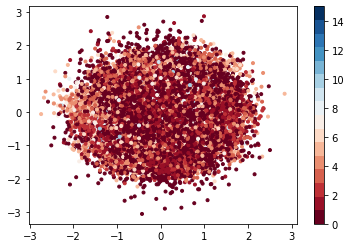

0 2


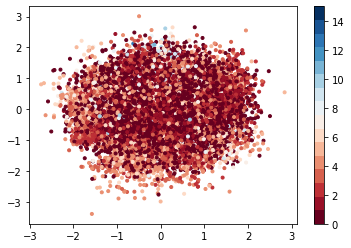

0 3


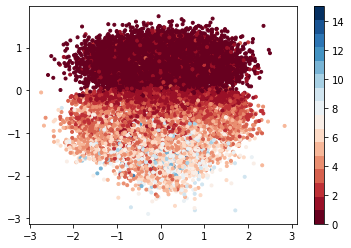

0 4


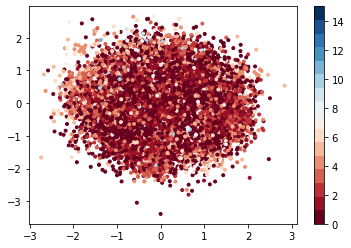

1 2


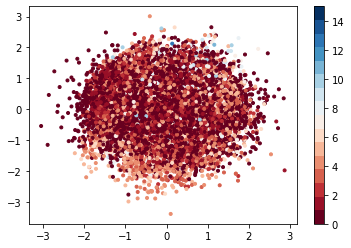

1 3


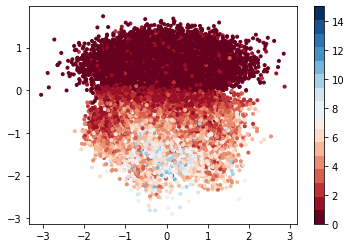

1 4


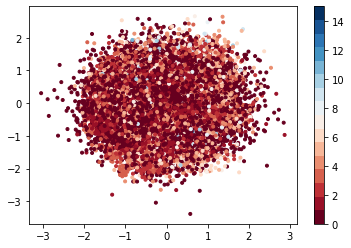

2 3


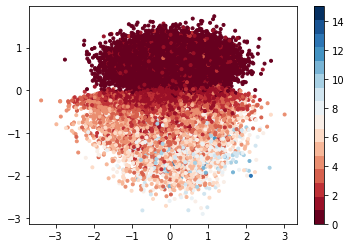

2 4


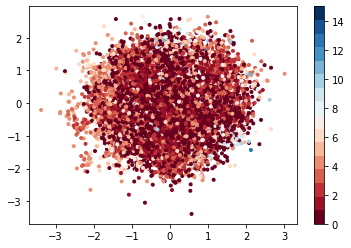

3 4


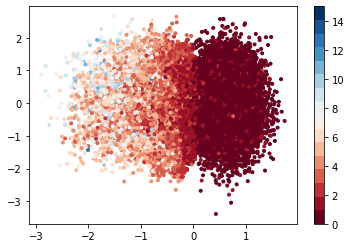

In [331]:
plot_latent(ae, val_data)

# Sample from variational encoder 
We sample from the latent encoder and compare the expectations.

In [332]:
latent_samples = ae.encoder.N.sample(torch.Size([10000,latent_dims]))

In [333]:
outputs = torch.round(ae.decoder(latent_samples))

In [334]:
correction = non_zero_train_data.shape[0] / train_data.shape[0] # for data trained on the 

Since, 

In [335]:
np.round(outputs.mean(axis=0).detach().numpy(),3)

array([0.002, 0.023, 0.008, 0.001, 0.023, 0.   , 0.037, 0.104, 0.051,
       0.   , 0.06 , 0.036, 0.04 , 0.002, 0.   , 0.026, 0.033, 0.016,
       0.   , 0.118, 0.065, 0.138, 0.   , 0.   , 0.137, 0.041, 0.002,
       0.001, 0.086, 0.111, 0.   , 0.023, 0.044, 0.165, 0.   , 0.012,
       0.069, 0.048, 0.006, 0.062], dtype=float32)

In [336]:
val_data.mean(axis=0)
np.round(val_data.mean(axis=0).detach().numpy(),3)

array([0.027, 0.008, 0.015, 0.016, 0.022, 0.022, 0.024, 0.08 , 0.041,
       0.006, 0.056, 0.028, 0.031, 0.01 , 0.004, 0.015, 0.045, 0.012,
       0.021, 0.117, 0.05 , 0.113, 0.016, 0.004, 0.097, 0.047, 0.008,
       0.028, 0.068, 0.062, 0.019, 0.037, 0.046, 0.134, 0.023, 0.019,
       0.048, 0.041, 0.028, 0.05 ], dtype=float32)

## Looking at the hamming distance on validation data

In [337]:
recon = ae(val_data)

In [338]:
Ks = val_data.sum(axis=1)

In [339]:
def hamming(data, recon):
    XORS = data * (1-recon) + (1-data) * recon
    return XORS.sum(1)

In [343]:
print("Mean hamming distance: ", np.round(torch.mean(hamming(val_data, torch.round(ae(val_data)))).item(),3),end=", ")
print("Model which only predicts 0...0: ", np.round(torch.mean(hamming(val_data, torch.zeros(val_data.shape))).item(),3))

print("Hamming distances")
print("%2s %5s %4s %4s" % ("K", "obvs", "mean", "max"))

for K in range(int(torch.max(Ks))+1):
    states_K_fire = val_data[Ks==K]
    recon = torch.round(ae(states_K_fire))
    ham_dists = hamming(states_K_fire,recon)
    N_samples = states_K_fire.shape[0]
    print("%2s %5s %.2f %3s" % (K, N_samples, float(torch.mean(ham_dists)), int(torch.max(ham_dists)) ))

Mean hamming distance:  0.465, Model which only predicts 0...0:  1.538
Hamming distances
 K  obvs mean  max
 0 21573 0.01   3
 1  7391 0.22   3
 2  5091 0.43   4
 3  3721 0.72   4
 4  2834 1.10   5
 5  1905 1.61   6
 6  1260 2.15   6
 7   779 2.77   7
 8   394 3.48   8
 9   229 4.13   8
10   121 4.88   8
11    46 5.28   9
12    11 5.55   8
13     6 6.67   8
14     1 8.00   8
15     1 8.00   8


In [341]:
states_K_fire = val_data[Ks==5]
recons = torch.round(ae(states_K_fire))
for state, recon in zip(states_K_fire, recons):
    print(state.numpy())
    print(recon.detach().numpy())
    print("----")

[0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 1. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 1. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
----
[0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
[0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
----
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 1. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
----
[0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1.]
[0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 1.]
-

 0. 0. 0. 0. 0. 1. 0. 1. 0. 1. 0. 0. 1. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0.]
----
[0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
----
[0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
----
[0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 1. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
----
[1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0.
 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0.
 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
----
[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 1. 0. 0. 0. 1. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 1. 0. 0. 0. 1. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0.]
----
[0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 1. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 1. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
----
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 1. 0. 0. 0. 0. 1. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 1. 0. 0. 0. 0. 1. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0.]
-

----
[0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0.
 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
----
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0.
 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1.]
----
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 1. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0.]
----
[0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 1. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 1. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 